# CRT hit analysis

In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import linregress
import numpy.polynomial.polynomial as poly
import matplotlib.patches as patches

In [2]:
%matplotlib inline

## Load the data

In [3]:
file_name_mc = './input/CosmicStudiesCRT_mc_75k_mcc9.root'
file_name_data = './input/CosmicStudiesCRT_run3_48k_mcc9.root'
outdir = './Output/CRThits/'

In [4]:
file_mc = uproot.open(file_name_mc)['cosmicstudies']
file_crtsim = uproot.open(file_name_mc)['crtdata/CRT']
file_data = uproot.open(file_name_data)['crtdata/CRT']

In [5]:
print(file_mc.keys())
df_crt_mc = file_mc[b'CRTcross'].pandas.df()
df_crt_mc = df_crt_mc.query('mc_neutrino_origin==0')
df_crt_mc['adj_check'] = (df_crt_mc['event'] != df_crt_mc['event'].shift()).cumsum()
num_crt_per_event_mc = df_crt_mc.groupby('adj_check').size()
num_events_mc = len(num_crt_per_event_mc)
print(file_mc[b'CRTcross'].keys())
print(num_events_mc)

[b'pot;1', b'Event;1', b'MCParticles;1', b'OpBeamFlashes;1', b'SimpleBeamFlashes;1', b'OpCosmicFlashes;1', b'SimpleCosmicFlashes;1', b'PFParticles;1', b'Clusters;1', b'CRTcross;1']
[b'event', b'run', b'subrun', b'num_mcp', b'cross_x', b'cross_y', b'cross_z', b'cross_time', b'cross_E', b'mc_time', b'mc_pdg_code', b'mc_process', b'mc_energy', b'mc_neutrino_origin']
80000


In [37]:
df_crtsim = file_crtsim.pandas.df().query('pe>40')
df_crtsim_lowpe = file_crtsim.pandas.df().query('pe<40 & plane==0')
# Smart groupby in events only if adjecent to avoid the duplicate events.
df_crtsim['adj_check'] = (df_crtsim['event'] != df_crtsim['event'].shift()).cumsum()
num_crtsim_per_event = df_crtsim.groupby('adj_check').size()
adj_check = (df_crtsim.query('plane==0')['event'] != df_crtsim.query('plane==0')['event'].shift()).cumsum()
num_crtsim_per_event_bottom = df_crtsim.query('plane==0').groupby(['event', adj_check]).size()
num_events_sim = len(num_crtsim_per_event)
print(num_events_sim)

70556


In [7]:
df_crtdata = file_data.pandas.df()
print(file_data.keys())
df_crtdata['adj_check'] = (df_crtdata['event'] != df_crtdata['event'].shift()).cumsum()
num_crtdata_per_event = df_crtdata.groupby('adj_check').size()
num_crtdata_per_event_bottom = df_crtdata.query('plane==0').groupby(['run', 'subrun', 'event']).size()
num_events_data = len(num_crtdata_per_event)
print(num_events_data)

[b'event', b'run', b'subrun', b'nhits', b'plane', b'time', b'pe', b'x', b'x_err', b'y', b'y_err', b'z', b'z_err', b't0_ns', b't1_ns']
48989


In [8]:
file_mc['Event'].numentries
# Due to some problem in processing the files, Only 70556/80000 events have CRT simulated hits, we will asume this is a random effect and introduce an extra scale:
mcall_scale = num_events_data/file_mc['Event'].numentries
event_scale = num_events_data/num_events_sim
print(event_scale)

0.6943279097454504


In [9]:
df_crt_mc["mc_pdg_code"].value_counts()/len(df_crt_mc["mc_pdg_code"])

-13      4.322109e-01
 13      3.608823e-01
 2112    1.935220e-01
 11      9.866972e-03
-11      2.610948e-03
 2212    6.879835e-04
-211     1.206513e-04
 211     9.557210e-05
-2212    2.033449e-06
-2112    6.778163e-07
Name: mc_pdg_code, dtype: float64

In [38]:
t_min_mc = -4.05
t_max_mc = 3.20
t_min_data = -1.9314
t_max_data = 4.0686
t_mc = t_max_mc - t_min_mc
t_data = t_max_data - t_min_data

x_min = -130
x_size = 515
z_min = 280
z_size = 260
area= x_size*z_size/1e4
coincide = 0.3

df_crt_mc['weight'] = mcall_scale
df_crtsim['weight'] = event_scale
df_crtdata['weight'] = 1

# take into account full exposure time
df_crt_mc['time_weight'] = mcall_scale*t_data/t_mc
df_crtsim['time_weight'] = event_scale*t_data/t_mc
df_crtdata['time_weight'] = 1

# Only bottom panel
df_crtsim_b = df_crtsim.query('plane==0')
df_crtdata_b = df_crtdata.query('plane==0')

# Sort hits on time:
df_crt_mc = df_crt_mc.sort_values(by=['adj_check','cross_time'])
df_crtsim_b = df_crtsim_b.sort_values(by=['adj_check','t1_ns'])
df_crtdata_b = df_crtdata_b.sort_values(by=['adj_check','time'])

df_crt_mc = df_crt_mc.query('abs(mc_pdg_code)==13')

df_crt_mc['dt_prev'] = (df_crt_mc['cross_time']-np.roll(df_crt_mc['cross_time'],1))/1000 
df_crtsim_b['dt_prev'] = (df_crtsim_b['t1_ns']-np.roll(df_crtsim_b['t1_ns'],1))/5000
df_crtdata_b['dt_prev'] = (df_crtdata_b['time']-np.roll(df_crtdata_b['time'],1))

df_crt_mc['coincidental'] = df_crt_mc.eval('dt_prev+(dt_prev<0)*@t_mc*1000')<coincide
df_crtsim_b['coincidental'] = df_crtsim_b.eval('dt_prev+(dt_prev<0)*@t_mc*1000')<coincide
df_crtdata_b['coincidental'] = df_crtdata_b.eval('dt_prev+(dt_prev<0)*@t_data*1000')<coincide

# Restricted area bottom panel
mask = df_crt_mc['cross_x'].between(x_min,x_min+x_size) & df_crt_mc['cross_z'].between(z_min,z_min+z_size)
df_crt_mc_br = df_crt_mc[mask].copy()
mask = df_crtsim_b['x'].between(x_min,x_min+x_size) & df_crtsim_b['z'].between(z_min,z_min+z_size)
df_crtsim_br = df_crtsim_b[mask].copy()
mask = df_crtdata_b['x'].between(x_min,x_min+x_size) & df_crtdata_b['z'].between(z_min,z_min+z_size)
df_crtdata_br = df_crtdata_b[mask].copy()


#mask = df_crtsim_lowpe['x'].between(x_min,x_min+x_size) & df_crtsim_lowpe['z'].between(z_min,z_min+z_size)
#df_crtsim_lowpe = df_crtsim_lowpe[mask]

# Add the time since the previous hit on the bottom panel (in us)
df_crt_mc_br['dt_prev'] = (df_crt_mc_br['cross_time']-np.roll(df_crt_mc_br['cross_time'],1))/1000 
df_crtsim_br['dt_prev'] = (df_crtsim_br['t1_ns']-np.roll(df_crtsim_br['t1_ns'],1))/5000
df_crtdata_br['dt_prev'] = (df_crtdata_br['time']-np.roll(df_crtdata_br['time'],1))

df_crt_mc_br['dt_prev'] = df_crt_mc_br.eval('dt_prev+(dt_prev<0)*@t_mc*1000')
df_crtsim_br['dt_prev'] = df_crtsim_br.eval('dt_prev+(dt_prev<0)*@t_mc*1000')
df_crtdata_br['dt_prev'] = df_crtdata_br.eval('dt_prev+(dt_prev<0)*@t_data*1000')

In [11]:
df_crt_mc_br['mc_pdg_code'].value_counts()/len(df_crt_mc_br)

-13    0.545533
 13    0.454467
Name: mc_pdg_code, dtype: float64

## Plots data/MC

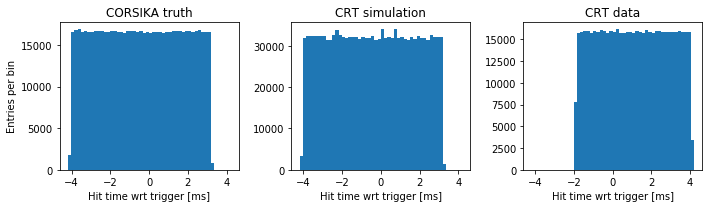

In [12]:
# Hit timing
fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharex = True)

ax[0].hist(df_crt_mc['cross_time']/1e6, bins=50, range=(-4.2,4.2), weights = df_crt_mc['weight'])
ax[1].hist(df_crtsim_b['t1_ns']/5e6, bins=50, range=(-4.2,4.2), weights = df_crtsim_b['weight'])
ax[2].hist(df_crtdata_b['time']/1e3, bins=50, range=(-4.2,4.2))

ax[0].set_xlabel('Hit time wrt trigger [ms]')
ax[1].set_xlabel('Hit time wrt trigger [ms]')
ax[2].set_xlabel('Hit time wrt trigger [ms]')
ax[0].set_ylabel('Entries per bin')

ax[0].set_title("CORSIKA truth")
ax[1].set_title("CRT simulation")
ax[2].set_title("CRT data")

fig.tight_layout()
plt.savefig(outdir+"crt_time_hits.pdf", bbox_inches="tight")

((275.0001220703125, 799.9996948242188), (-129.99920654296875, 399.99822998046875))
((273.2196960449219, 780.4843139648438), (-137.14129638671875, 392.123291015625))
((276.883544921875, 776.9459838867188), (-133.0609588623047, 389.1341247558594))


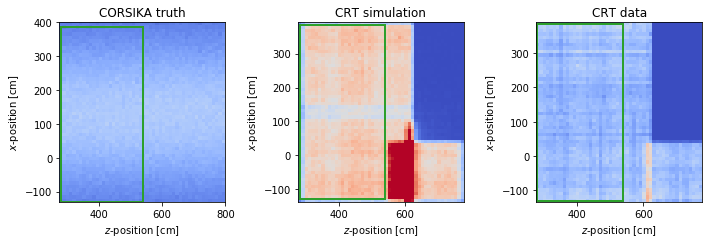

In [13]:
# Hit surface
fig, ax = plt.subplots(1, 3, figsize=(10, 3.5), sharex = False)

for i, df in enumerate([df_crt_mc, df_crtsim_b, df_crtdata_b]): 
    
    f = ['x','z']
    if (i==0):
        f = ['cross_'+x for x in f]
    
    xz_data = ((min(df[f[1]]),max(df[f[1]])),
               (min(df[f[0]]),max(df[f[0]])))
    print(xz_data)

    ax[i].hist2d(df[f[1]],df[f[0]],
                 cmap='coolwarm', bins=(50,52), range = xz_data, weights = df['time_weight'], vmin=0, vmax =900 )
    ax[i].set_xlabel(r'$z$-position [cm]')
    ax[i].set_ylabel(r'$x$-position [cm]')

    rect = patches.Rectangle((z_min,x_min),z_size,x_size,
                         linewidth=2,edgecolor='C2',facecolor='none', label='TPC')
    
    ax[i].add_patch(rect)

ax[0].set_title("CORSIKA truth")
ax[1].set_title("CRT simulation")
ax[2].set_title("CRT data")

fig.tight_layout()
plt.savefig(outdir+"crt_bottom_hits2d_rect.pdf", bbox_inches="tight")

In [14]:
# Hit rate before removing coincidentals
hits_mc = len(df_crt_mc_br)
hits_sim = len(df_crtsim_br)
hits_data = len(df_crtdata_br)

rate_mc = hits_mc/(t_mc*1e-3*num_events_mc)/(area)
rate_sim = hits_sim/(t_mc*1e-3*num_events_sim)/(area)
rate_data = hits_data/(t_data*1e-3*num_events_data)/(area)
print(rate_mc)
print(rate_sim)
print(rate_data)
print(t_mc*1e-3*num_events_mc / len(df_crt_mc_br))

73.62841544127114
169.03874569838422
91.20081434710416
0.0010143176178226097


-0.001001280727160308 8.883429483435783
2.618856692302539e-06
[-1.00128073e-03  8.88342948e+00]
Rate = 74.8 +/- 0.2 [/m*m*s]
-0.0015645183712402453 9.792139243496457
3.0081252617566517e-06
[-1.56451837e-03  9.79213924e+00]
Rate = 116.8 +/- 0.2 [/m*m*s]
-0.0011961771054798378 9.2572643640666
3.647262257014198e-06
[-1.19617711e-03  9.25726436e+00]
Rate = 89.3 +/- 0.3 [/m*m*s]


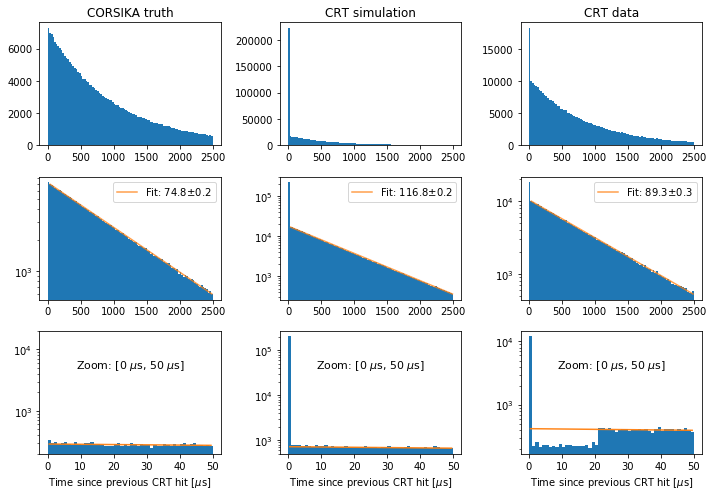

In [15]:
# Try to estimate dead time of hits and coincidental hits, first add the time of the previous hit (all hits or area constrained?)
fig, ax = plt.subplots(3, 3, figsize=(10, 7), sharex = 'row')

x_max = 2500
N = 100
x_max_zoom = 50
N_zoom = 50
skip_bins = 1

for i, df in enumerate([df_crt_mc_br, df_crtsim_br,df_crtdata_br]): 
    if i==0:
        df=df.query('abs(mc_pdg_code)==13')
        ax[2][i].set_ylim(2e2,2e4)
    bins, edges, _ = ax[0][i].hist(df['dt_prev'], bins=N, range=(0,x_max), weights= df['time_weight'])
    
    #--fit--------------------------------------------------------------------------------------
    centers = edges[:-1] + np.diff(edges)/2
    slope, intercept, r_value, p_value, std_err = linregress(centers[skip_bins:], np.log(bins[skip_bins:]))
    coefs = np.polyfit( centers[skip_bins:],np.log(bins[skip_bins:]),1)
    ffit = poly.polyval(centers[skip_bins:], [intercept,slope])
    print(slope, intercept)
    print(std_err)
    print(coefs)
    print(r"Rate = {0:.1f} +/- {1:.1f} [/m*m*s]".format(slope*-1e6/area, std_err*1e6/area ) )
    #--------------------------------------------------------------------------------------------


    bins, edges, _ = ax[1][i].hist(df['dt_prev'], bins=N, range=(0,x_max), weights= df['time_weight'], label='')
    ax[1][i].plot(centers[skip_bins:],np.exp(ffit), label = r"Fit: {0:.1f}$\pm${1:.1f}".format(slope*-1e6/area, std_err*1e6/area ), 
                  lw=1.5, alpha=0.75)
    ax[1][i].set_yscale('log')
    ax[1][i].legend()
    
    bins, edges, _ = ax[2][i].hist(df['dt_prev'], bins=N_zoom, range=(0,x_max_zoom), weights= df['time_weight'])
    centers = edges[:-1] + np.diff(edges)/2
    ffit = poly.polyval(centers, [intercept,slope])
    ax[2][i].plot(centers,np.exp(ffit)/25, label = 'exp fit', lw=1.5, alpha=0.95)
    ax[2][i].annotate(r'Zoom: [0 $\mu$s, 50 $\mu$s]', xy=(0.2,0.7), fontsize=11, xycoords='axes fraction')
    ax[2][i].set_yscale('log')
    ax[2][i].set_xlabel(r"Time since previous CRT hit [$\mu$s]")

ax[0][0].set_title("CORSIKA truth")
ax[0][1].set_title("CRT simulation")
ax[0][2].set_title("CRT data")

fig.tight_layout()
plt.savefig(outdir+"crt_time_diff.pdf", bbox_inches="tight")

-0.001001280727160308 8.883429483435783
2.618856692302539e-06
[-1.00128073e-03  8.88342948e+00]
Rate = 74.8 +/- 0.2 [/m*m*s]
-0.0015645183712402453 9.792139243496457
3.0081252617566517e-06
[-1.56451837e-03  9.79213924e+00]
Rate = 116.8 +/- 0.2 [/m*m*s]
-0.0011961771054798378 9.2572643640666
3.647262257014198e-06
[-1.19617711e-03  9.25726436e+00]
Rate = 89.3 +/- 0.3 [/m*m*s]


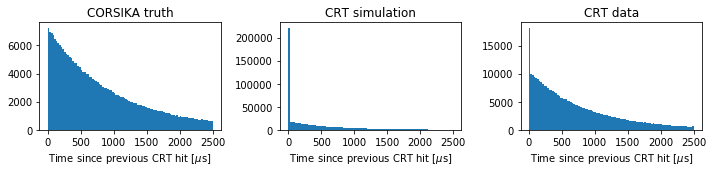

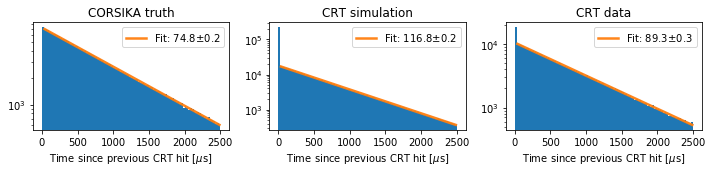

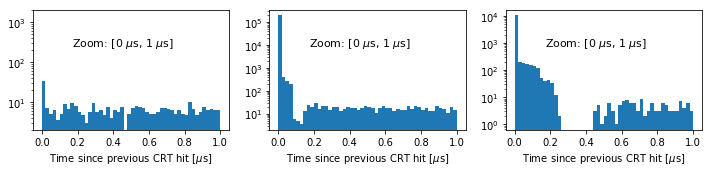

In [16]:
# Try to estimate dead time of hits and coincidental hits, first add the time of the previous hit (all hits or area constrained?)
fig0, ax0 = plt.subplots(1, 3, figsize=(10, 2.5), sharex = 'row')
fig1, ax1 = plt.subplots(1, 3, figsize=(10, 2.5), sharex = 'row')
fig2, ax2 = plt.subplots(1, 3, figsize=(10, 2.5), sharex = 'row')


x_max = 2500
N = 100
x_max_zoom = 1
N_zoom = 50
skip_bins = 1

for i, df in enumerate([df_crt_mc_br, df_crtsim_br,df_crtdata_br]): 
    if i==0:
        df=df.query('abs(mc_pdg_code)==13')
        ax2[i].set_ylim(2e0,2e3)
    bins, edges, _ = ax0[i].hist(df['dt_prev'], bins=N, range=(0,x_max), weights= df['time_weight'])
    
    #--fit--------------------------------------------------------------------------------------
    centers = edges[:-1] + np.diff(edges)/2
    slope, intercept, r_value, p_value, std_err = linregress(centers[skip_bins:], np.log(bins[skip_bins:]))
    coefs = np.polyfit( centers[skip_bins:],np.log(bins[skip_bins:]),1)
    ffit = poly.polyval(centers[skip_bins:], [intercept,slope])
    print(slope, intercept)
    print(std_err)
    print(coefs)
    print(r"Rate = {0:.1f} +/- {1:.1f} [/m*m*s]".format(slope*-1e6/area, std_err*1e6/area ) )
    #--------------------------------------------------------------------------------------------


    bins, edges, _ = ax1[i].hist(df['dt_prev'], bins=N, range=(0,x_max), weights= df['time_weight'], label='')
    ax1[i].plot(centers[skip_bins:],np.exp(ffit), label = r"Fit: {0:.1f}$\pm${1:.1f}".format(slope*-1e6/area, std_err*1e6/area ), 
                  lw=2.5, alpha=0.95)
    ax1[i].set_yscale('log')
    ax1[i].legend()
    
    bins, edges, _ = ax2[i].hist(df['dt_prev'], bins=N_zoom, range=(0,x_max_zoom), weights= df['time_weight'])
    centers = edges[:-1] + np.diff(edges)/2
    ffit = poly.polyval(centers, [intercept,slope])
    #ax2[i].plot(centers,np.exp(ffit)/(x_max/x_max_zoom), label = 'exp fit', lw=1.5, alpha=0.95)
    ax2[i].annotate(r'Zoom: [0 $\mu$s, 1 $\mu$s]', xy=(0.2,0.7), fontsize=11, xycoords='axes fraction')
    ax2[i].set_yscale('log')
    
    ax0[i].set_xlabel(r"Time since previous CRT hit [$\mu$s]")
    ax1[i].set_xlabel(r"Time since previous CRT hit [$\mu$s]")
    ax2[i].set_xlabel(r"Time since previous CRT hit [$\mu$s]")

ax0[0].set_title("CORSIKA truth")
ax0[1].set_title("CRT simulation")
ax0[2].set_title("CRT data")
ax1[0].set_title("CORSIKA truth")
ax1[1].set_title("CRT simulation")
ax1[2].set_title("CRT data")

fig0.tight_layout()
fig1.tight_layout()
fig2.tight_layout()
fig0.savefig(outdir+"crt_time_diff0.pdf", bbox_inches="tight")
fig1.savefig(outdir+"crt_time_diff1.pdf", bbox_inches="tight")
fig2.savefig(outdir+"crt_time_diff3.pdf", bbox_inches="tight")

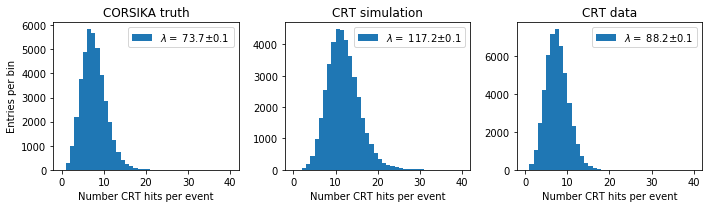

In [17]:
### Hits per event
fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharex = True)

for i, (df,t) in enumerate(zip([df_crt_mc_br, df_crtsim_br, df_crtdata_br],[t_mc, t_mc, t_data])):
    
    num = df.query('dt_prev>0.3').groupby('adj_check').size()
    rate= np.mean(num)/area/(t/1000)
    err = np.sqrt(np.mean(num)/len(num))/area/(t/1000)
    ax[i].hist(num, bins=40, range=(0,40), weights = [df.iloc[0]['time_weight']]*len(num),
                  label = r"$\lambda =$ {0:.1f}$\pm${1:.1f}".format(rate,err))
    ax[i].set_xlabel("Number CRT hits per event")
    ax[i].legend()

ax[0].set_ylabel('Entries per bin')
ax[0].set_title("CORSIKA truth")
ax[1].set_title("CRT simulation")
ax[2].set_title("CRT data")

fig.tight_layout()
fig.savefig(outdir+"crt_num_hits.pdf", bbox_inches="tight")

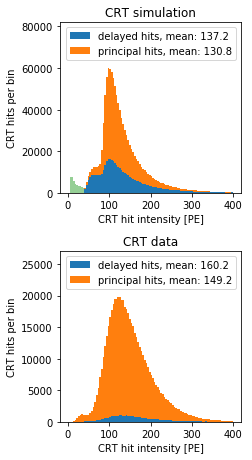

In [40]:
# Hit PE, be carefull, in the simulation, some hits have crazy high pe, cut off at 1e3

fig, ax = plt.subplots(2, 1, figsize=(3.6, 6.5), sharex = False)

for i, df in enumerate([df_crtsim_b, df_crtdata_b]): 
    ax[i].hist([df.query('coincidental')['pe'], df.query('~coincidental')['pe']], range=(0,400), bins=100, histtype='barstacked',
               weights = [df.query('coincidental')['time_weight'], df.query('~coincidental')['time_weight']],
               label = [r"delayed hits, mean: {0:.1f}".format(df.query('coincidental')['pe'][df.query('coincidental')['pe']<500].mean()),
                        r"principal hits, mean: {0:.1f}".format(df.query('~coincidental')['pe'][df.query('~coincidental')['pe']<500].mean())])
    ax[i].set_xlabel(r'CRT hit intensity [PE]')
    ax[i].set_ylabel(r'CRT hits per bin')
    ax[i].legend()
    ax[i].set_ylim(0,ax[i].get_ylim()[1]*1.3)
    
    
ax[0].hist(df_crtsim_lowpe["pe"],alpha=0.5, bins=100, range=(0,400), weights= [event_scale*t_data/t_mc]*len(df_crtsim_lowpe["pe"]) )
ax[0].set_title("CRT simulation")
ax[1].set_title("CRT data")

fig.tight_layout()
plt.savefig(outdir+"crt_pe_hits_1.pdf", bbox_inches="tight")

In [19]:
area

13.39